# Speech Recognition with Smartphone Accelerometers

There are many sensors on smartphones to detect the change of the environment or the user activity. The Apps on the smartphone need to request permission to use some sensors, like accessing a speakers, camera, or fingerprints. While other sensors don't need permissions to access, like motion sensors or light sensors. 

As the speaker is close to the accelerometer and when the speaker is making a sound, it can have an impact on the accelerometer. In this project, I would like to show how to exploit accelerometers to achieve speech recognition with accelerometers.

## Setup

Import necessary modules and dependencies.

The project use [Tensorflow 2.0](https://www.tensorflow.org/) to build the deep learning model.

In [1]:
%config IPCompleter.greed=True

import seaborn as sns
import scipy.signal as sg
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models

import acc_util

c:\program files\python 3\lib\site-packages\IPython\core\interactiveshell.py:3418: UserWarning: Config option `greed` not recognized by `IPCompleter`.  Did you mean `greedy`?
  exec(code_obj, self.user_global_ns, self.user_ns)


## Import dataset

I will use [Audio MNIST](https://www.kaggle.com/alanchn31/free-spoken-digits) that contains 30,000 audio samples of spoken digits. The dataset will be the raw input of my Android app to collect accelerometer data.

The accelerometer data has three axes that represent the acceleration changes on the smartphone.

In [2]:
acc_data, label, timestamp = acc_util.read_acc_file('./dataset')
print('Dataset shape', np.shape(acc_data))
print('label', set(label))
print(type(acc_data))

Dataset shape (3, 3000)
label {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
<class 'numpy.ndarray'>


Plot the dataset of accelerometer

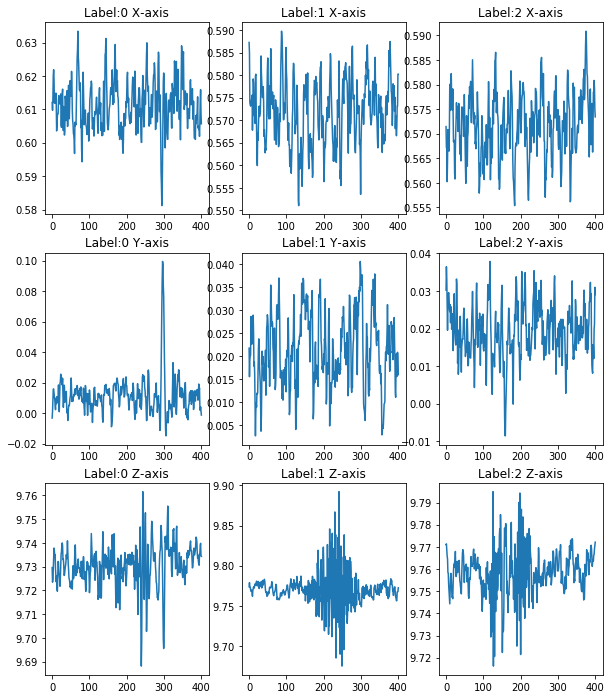

In [3]:
R = 3
C = 3
n = R * C
fig, axes = plt.subplots(R, C, figsize=(10, 12))
for col in range(C):
    for row in range(R):
        ax = axes[row][col]
        ax.plot(acc_data[row][col*300])
        # ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
        axis = "X" if row == 0 else "Y" if row == 1 else "Z"
        title = "Label:{0} {1}-axis".format(label[col*300], axis)
        ax.set_title(title)
plt.show() 

## Preprocess dataset

To eliminate noise on the acceleration signal and minimize distortions caused by hardware and human activities, I implement a high-pass filter to each axis of the acceleration signal and eliminate frequency components below 80 Hz.

The next step is signal-to-spectrogram conversion. To fit the model, the input data should be an image. So I use short-time Fourier transform to convert the signal to the spectrogram

Plot the preprocessing including high-pass filter and short-time Fourier transform.

(24, 17)


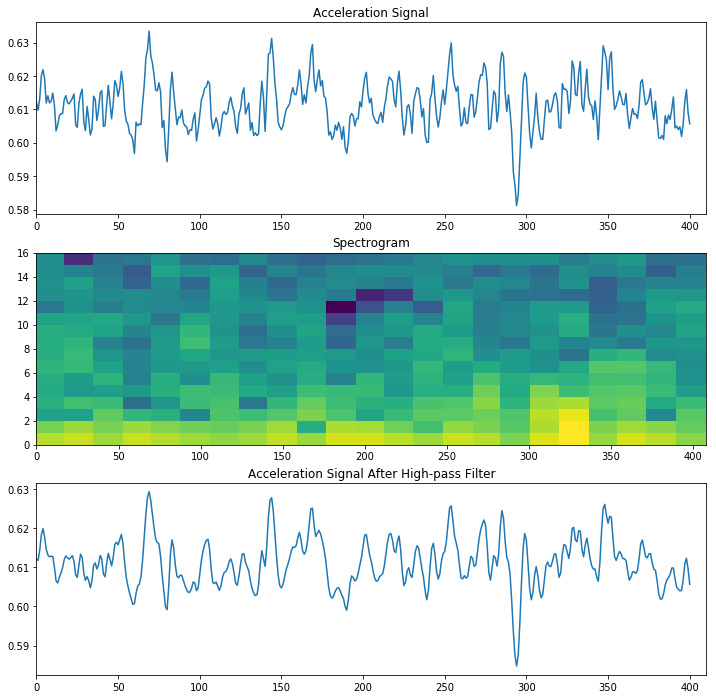

In [6]:
def get_spectrogram(waveform):
    #Padding file
    zero_pad = tf.zeros([410] - tf.shape(waveform), dtype=tf.float32)
    
    #Concatenate waveform with padding
    waveform = tf.cast(waveform, dtype=tf.float32)
    padded_wave = tf.concat([waveform, zero_pad], 0)
    spectrogram = tf.signal.stft(padded_wave, frame_length=30, frame_step=16)
    
    spectrogram = tf.abs(spectrogram)
    return spectrogram

def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  width = log_spec.shape[1]
  height = log_spec.shape[0]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

def waveform_filter(waveform):
    b, a = sg.butter(1, 80, 'low', fs=400)
    x_fil = sg.filtfilt(b, a, waveform)
    return x_fil

def wave_filter(wave):
    batch_num = len(wave[0])
    channel = len(wave)
    for c in range(channel):
        for b in range(batch_num):
            wave[c][b] = waveform_filter(wave[c][b])
    return wave

def data_transform(dataset):
    batch_num = len(dataset[0])
    channel = len(dataset)
    row, col = get_spectrogram(acc_data[0][0]).shape
    out = np.empty(shape=(batch_num, row, col, channel))
    for c in range(channel):
        for b in range(batch_num):
            spec = get_spectrogram(acc_data[c][b])
            out[b, :, :, c] = spec
    return out

spectrogram = get_spectrogram(acc_data[1][0])
print(spectrogram.shape)
fig, axes = plt.subplots(3, figsize=(12, 12))

# Plot the X-axis of acceleration signal
timescale = np.arange(len(acc_data[0][0]))
axes[0].plot(timescale, acc_data[0][0])
axes[0].set_title('Acceleration Signal')
axes[0].set_xlim([0, 410])

# Plot the spectorgram
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')

# Plot the signal after high-pass filter
axes[2].plot(timescale, waveform_filter(acc_data[0][0]))
axes[2].set_title('Acceleration Signal After High-pass Filter')
axes[2].set_xlim([0, 410])

plt.show()

Apply the processing to each axis of the accelerometer data.

In [7]:
WINDOW_SIZE = 16
OVERLAP = 8
SAMPLE_RATE = 500
SAMPLE_NUM = 300
PAD_LENGTH = 38

acc_data = wave_filter(acc_data)
stft = acc_util.STFTUtil(WINDOW_SIZE, SAMPLE_RATE, SAMPLE_NUM, OVERLAP)
wave = stft.cut(acc_data)
# stft.show_wave(wave[0, :, 0])
# stft.show_wave(wave[0, :, 1])
# stft.show_wave(wave[0, :, 2])

spec = stft.ft(wave)
spec = np.log(spec)
# stft.show_spec(spec[100,:,:,:])
# spec = data_transform(acc_data)

## Build and train the model

Resize the spectrogram image and split the dataset

In [8]:
spec = spec[:, 2:, 1:-1, :]
n_data, spec_length, time_length, channel_num = spec.shape

BATCH_SIZE = 256

data, label = shuffle(spec, label)
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.1)

input_shape = (spec_length, time_length, channel_num)
num_labels = len(set(label))

For the model, you'll use a simple convolutional neural network (CNN)

The input spectrogram image will go through two convolutional layers, a max-pooling layer, flatten layer, and a fully connected layer. Then output the possible digits of the speech signal.

In [9]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    # preprocessing.Resizing(16, 16),
    layers.BatchNormalization(),
    layers.Conv2D(16, 3, activation='relu'),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 7, 36, 3)          12        
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 34, 16)         448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 32, 32)         4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 16, 32)         0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 16, 32)         0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               6

In [8]:
# DenseNet

# covn_base = tf.keras.applications.DenseNet121(weights='imagenet',include_top=False,input_shape=(32,32,3))
# covn_base.trainable = True
# 

# for layers in covn_base.layers[:-5]:
#     layers.trainable = False
#     
    
# model = tf.keras.Sequential()
# model.add(covn_base)
# model.add(tf.keras.layers.GlobalAveragePooling2D())  
# model.add(tf.keras.layers.Dense(128,activation='relu'))  
# model.add(tf.keras.layers.Dropout(rate=0.5))  
# model.add(tf.keras.layers.Dense(10,activation='softmax'))  
# model.summary()  

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy',
             tf.keras.metrics.SparseTopKCategoricalAccuracy(3),
              # tf.keras.metrics.SparseTopKCategoricalAccuracy(5)
             ],
)

In [13]:
EPOCHS = 200
history = model.fit(x=X_train, y=y_train,
            batch_size=BATCH_SIZE, epochs=EPOCHS,
            validation_split=0.2,
            #   validation_data=(X_test, y_test),
            validation_freq=5,
            verbose=1)

Epoch 1/200
9/9 [==============================] - 0s 33ms/step - loss: 2.3558 - accuracy: 0.1111 - sparse_top_k_categorical_accuracy: 0.3125
Epoch 2/200
9/9 [==============================] - 0s 38ms/step - loss: 2.2230 - accuracy: 0.1606 - sparse_top_k_categorical_accuracy: 0.4324

## Evaluate the model

check the training and validation loss curves to see how your model has improved during training. Also, I use top 1 , top 3 , and top 5 accuracy to evaluate my model.

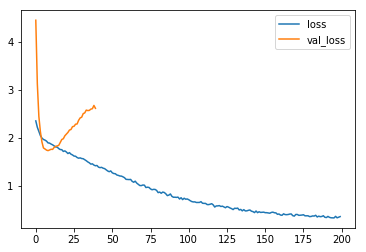

In [14]:
metrics = history.history

plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

Evaluate test set performance

In [15]:
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = y_test

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')


Test set accuracy: 43%


Display a confusion matrix

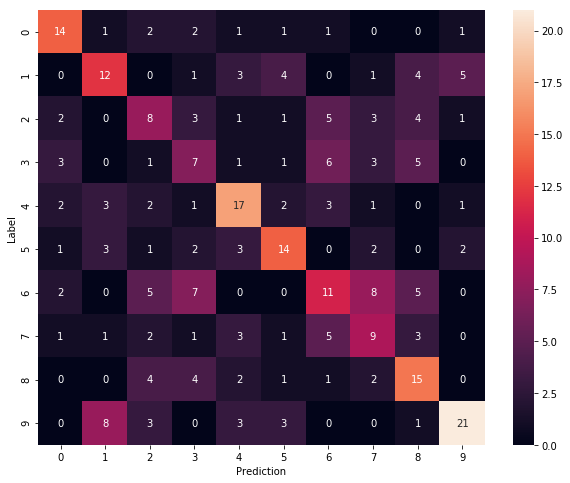

In [16]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=set(label), yticklabels=set(label), 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()